In [1]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain-openai langchainhub langchain-community

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

open_ai_key = os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")

In [3]:
## Modelo de embeddings
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

model = ChatOpenAI(model="gpt-4o", temperature=0)
embedder = OpenAIEmbeddings()

In [7]:
from langchain_community.document_loaders import PyPDFLoader

# cargar documentos
loader = PyPDFLoader("example_data/meeting_data.pdf")
paper = loader.load()

In [9]:
from langchain.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)

# text splits for the document
chunks_paper = text_splitter.split_documents(paper)

# storing in vector store
faiss_db_paper = FAISS.from_documents(chunks_paper, embedder)


In [10]:
## creating retriever

retriever_paper = faiss_db_paper.as_retriever()

In [59]:
 # Convertimos el retriever en una tool

from langchain.tools.retriever import create_retriever_tool

retrieval_tool = create_retriever_tool(retriever_paper, "rag_tool", "Busca información en el documento")

In [60]:
retrieval_tool.invoke("¿Cuándo fue la reunion?")

'Reunión de planificación - 15 de agosto de 2024\nAsistentes:\n- Juan Pérez\n- María González\n- Luis Fernández\n- Ana Martínez\nAgenda:\n1. Revisión de los objetivos del trimestre pasado.\n2. Planificación de las próximas actividades.\n3. Asignación de responsabilidades.\n4. Preguntas y respuestas.\nConclusiones:\n- Se logró el 85% de los objetivos del trimestre pasado.\n- Se identificaron áreas de mejora en la comunicación interna.\n- Las actividades prioritarias para el próximo trimestre incluyen la mejora de procesos y la\ncapacitación del personal.\nLa próxima reunión está programada para el 20 de septiembre de 2024.'

In [61]:
# Añade otras tools para tu agente

from langchain_community.utilities import ArxivAPIWrapper
from langchain_community.tools.wikipedia.tool import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper


# Tool para buscar en Wikipedia
wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

In [72]:
from langchain.tools import Tool

# Documenta tus tools 
wiki_tool = Tool.from_function(
    func=wikipedia.run,
    name="wiki_tool",
    description="useful for when you need to search certain topic on Wikipedia, aka wiki")


tools = [wiki_tool, retrieval_tool] 

In [63]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

In [64]:
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "RAG doc",
            "args": {"query": "¿Cuándo fue la reunion?"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})


{'messages': [ToolMessage(content='Error: RAG doc is not a valid tool, try one of [wiki_tool, rag_tool].', name='RAG doc', tool_call_id='tool_call_id')]}

### LangGraph - Graph

Nodos 

In [66]:
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode

tools = [retrieval_tool, wiki_tool]
tool_node = ToolNode(tools)
model = ChatOpenAI(model="gpt-4o", temperature=0).bind_tools(tools)

Decidir Continuar o Terminar

In [77]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


Llamada al Modelo y Definición del Grafo

In [78]:
def call_model(state: MessagesState):
    messages = state['messages']
    response = model.invoke(messages)
    return {"messages": [response]}

In [80]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", 'agent')


Compilación y Ejecución del Grafo

In [71]:
checkpointer = MemorySaver()
app = workflow.compile(checkpointer=checkpointer)

final_state = app.invoke(
    {"messages": [HumanMessage(content="¿Quiénes asistieron a la reunión del 15 de agosto?")]},
    config={"configurable": {"thread_id": 42}}
)
print(final_state["messages"][-1].content)


En la reunión del 15 de agosto de 2024, los asistentes fueron:

- Juan Pérez
- María González
- Luis Fernández
- Ana Martínez


In [ ]:
%pip install "langserve[all]"

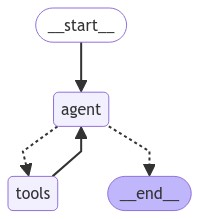

In [75]:
## graph
from langchain_core.runnables.graph import MermaidDrawMethod 
from IPython.display import display, HTML, Image

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)